# Download IMD Rain, Temp Data & convert to SWAT Weather input Format

In [5]:
# pip install imdlib

## Download

In [1]:
import imdlib as imd

start_yr = 1990
end_yr = 2022
variable = 'rain' # other options are ('tmin'/ 'tmax'/ 'rain')
file_dir = (r'E:\Rachit\IGBP_Project\Data\Weather_data\IMD') #Path to save the files
# imd.get_data(variable, start_yr, end_yr, fn_format='yearwise', file_dir=file_dir)

In [2]:
%pwd # present working directory

'e:\\Rachit\\IGBP_Project\\Data\\Weather_data\\IMD'

## grd to xarray

In [3]:
# CHANGE HERE ACC TO PARAMETER REQUIRED
data = imd.open_data('rain', 1990, 2022,'yearwise', file_dir) 


In [4]:
import xarray
ds = data.get_xarray()
print(ds)

<xarray.Dataset>
Dimensions:  (time: 12053, lat: 129, lon: 135)
Coordinates:
  * lat      (lat) float64 6.5 6.75 7.0 7.25 7.5 ... 37.5 37.75 38.0 38.25 38.5
  * lon      (lon) float64 66.5 66.75 67.0 67.25 67.5 ... 99.25 99.5 99.75 100.0
  * time     (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2022-12-31
Data variables:
    rain     (time, lat, lon) float64 -999.0 -999.0 -999.0 ... -999.0 -999.0
Attributes:
    Conventions:  CF-1.7
    title:        IMD gridded data
    source:       https://imdpune.gov.in/
    history:      2024-01-04 06:04:39.752559 Python
    references:   
    comment:      
    crs:          epsg:4326


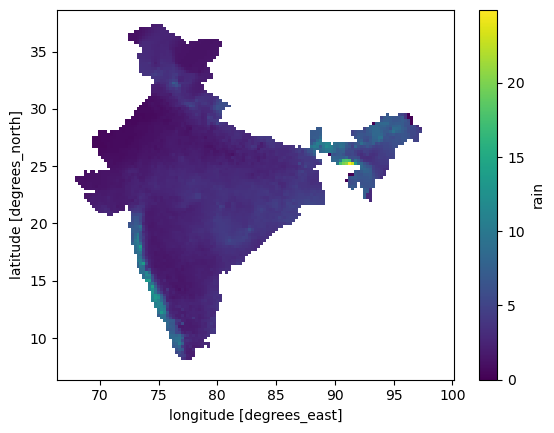

In [5]:
ds = ds.where(ds['rain'] != -999.) #Remove NaN values
ds['rain'].mean('time').plot()  # plotting the mean rainfall over the years

## Clipping all grd files using shapefile and saving as nc file 

### (will keep all coordinates within the rect extent of shapefile)

In [6]:
import imdlib as imd
import geopandas as gpd
from shapely.geometry import mapping
import rioxarray as rio
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import numpy as np

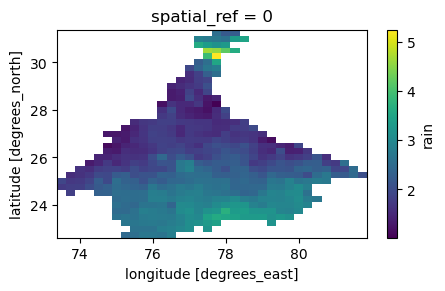

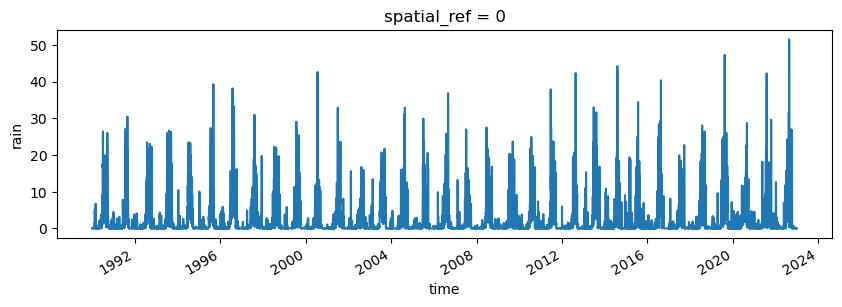

In [101]:
#Define lat/long 
pr = ds.rio.set_spatial_dims('lon', 'lat')
pr = pr.rio.write_crs("epsg:4326")

# Get the shapefile to be extracted
sf = gpd.read_file(r'E:\\Rachit\\IGBP_Project\\Yamuna_test_shp\\Yamuna_test_shp.shp')

# Extract/mask from the shapefile
clipped = pr.rio.clip(sf.geometry.apply(mapping), sf.crs, all_touched=False)           # clipped is an xarray dataset
# all_touched (bool, optional) – If True, all pixels touched by geometries will be burned in. If false, only pixels whose center is within the polygon or that are selected by Bresenham’s line algorithm will be burned in.

# Check for the values by plotting
fig, axs1 = plt.subplots(figsize=(5, 2.7))
clipped['rain'].mean('time').plot()
fig, axs2 = plt.subplots(figsize=(10, 2.7))
clipped['rain'].mean(axis=(1, 2)).plot.line()

# Save to file in NetCDF format
save_nc = (r'E:\Rachit\IGBP_Project\Data\Weather_data\IMD\rain\Yamuna_test\IMD_Rain_ClippedYamunatest.nc')
clipped.to_netcdf(save_nc)   # only execute to save new file

## Converting nc file to text files for SWAT weather input

### Rainfall

In [7]:
import rioxarray as rio
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point

In [8]:
ncfile = xr.open_dataset(r'E:\Rachit\IGBP_Project\Data\Weather_data\IMD\rain\Yamuna_test\IMD_Rain_ClippedYamunatest.nc')

In [9]:
df = ncfile.to_dataframe().reset_index()           # convert netcdf to dataframe and to reset the indexes according to netcdf dimensions
df

,lat,lon,time,spatial_ref,rain
0,22.75,73.50,1990-01-01,0,NaN
1,22.75,73.50,1990-01-02,0,NaN
2,22.75,73.50,1990-01-03,0,NaN
3,22.75,73.50,1990-01-04,0,NaN
4,22.75,73.50,1990-01-05,0,NaN
...,...,...,...,...,...
14343065,31.25,81.75,2022-12-27,0,NaN
14343066,31.25,81.75,2022-12-28,0,NaN
14343067,31.25,81.75,2022-12-29,0,NaN
14343068,31.25,81.75,2022-12-30,0,NaN


In [10]:
non_null_rows = df.dropna(subset=['rain'])         # REMOVED NAN VALUES (values of coordinates within the extent of shapefile)
non_null_rows

,lat,lon,time,spatial_ref,rain
84371,22.75,75.25,1990-01-01,0,0.000000
84372,22.75,75.25,1990-01-02,0,0.000000
84373,22.75,75.25,1990-01-03,0,0.000000
84374,22.75,75.25,1990-01-04,0,0.000000
84375,22.75,75.25,1990-01-05,0,0.000000
...,...,...,...,...,...
14174323,31.25,78.25,2022-12-27,0,0.000000
14174324,31.25,78.25,2022-12-28,0,0.000000
14174325,31.25,78.25,2022-12-29,0,0.000000
14174326,31.25,78.25,2022-12-30,0,3.581628


# -------------------------------------------------------------------------------------------

In [107]:
# # Convert DataFrame to a GeoDataFrame by creating a geometry column with Point geometries
# geometry = [Point(xy) for xy in zip(non_null_rows['lat'], non_null_rows['lon'])]
# gdf = gpd.GeoDataFrame(non_null_rows, geometry=geometry, crs="+proj=lcc +lat_1=12.472944444 +lat_2=35.172805555556 +lat_0=24 +lon_0=80 +x_0=4000000 +y_0=4000000 +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

In [108]:
# gdf.crs

In [109]:
# gdf.set_crs("+proj=lcc +lat_1=12.472944444 +lat_2=35.172805555556 +lat_0=24 +lon_0=80 +x_0=4000000 +y_0=4000000 +ellps=WGS84 +datum=WGS84 +units=m")

In [29]:
# perform a spatial join between GeoDataFrame and the shapefile. This will assign each point in DataFrame to the corresponding polygon in the shapefile.
# sf = gpd.read_file(r'E:\\Rachit\\IGBP_Project\\Yamuna_test_shp\\Yamuna_test_shp.shp')
# gdf_joined = gpd.sjoin(gdf, sf, how='inner', predicate='within')
# gdf_joined

In [31]:
# sf

# -------------------------------------------------------------------------------------------

In [11]:
group = non_null_rows[['lat' , 'lon']].drop_duplicates() # To store lat lon pair in a separate dataframe and keep only unique combinations
print(group.iloc[0]['lat']) # To access the value of a particular entry in a particular column of a DataFrame
print(group)

22.75
            lat    lon
84371     22.75  75.25
96424     22.75  75.50
108477    22.75  75.75
120530    22.75  76.00
132583    22.75  76.25
...         ...    ...
13752473  31.00  78.25
13764526  31.00  78.50
14138169  31.25  77.75
14150222  31.25  78.00
14162275  31.25  78.25

[496 rows x 2 columns]


In [44]:
# SAMPLE CHECK
# filtered_df = non_null_rows[(non_null_rows['lat'] == group.iloc[0]['lat']) & (non_null_rows['lon'] == group.iloc[0]['lon'])]
# filtered_df

In [12]:
for i in range(len(group)):
    filtered_df = non_null_rows[(non_null_rows['lat'] == group.iloc[i]['lat']) & (non_null_rows['lon'] == group.iloc[i]['lon'])]
    rain = filtered_df["rain"]
    rain.to_csv(f"E:/Rachit/IGBP_Project/Data/Weather_data/IMD/rain/Yamuna_test/rain{group.iloc[i]['lat']}_{group.iloc[i]['lon']}.txt".format(i), header=['19900101'], index=None, mode='w')

#### Rain input file

##### --getting elevation values from DEM

In [13]:
### Converting dataframe to shapefile
import geopandas as gpd
import pandas as pd

In [ ]:
# assuming the dataframe is named 'df' and has columns 'latitude' and 'longitude'
geometry = gpd.points_from_xy(group.lon, group.lat)
gdfele = gpd.GeoDataFrame(group, geometry=geometry, crs='EPSG:4326')

# save the GeoDataFrame as a shapefile
gdfele.to_file('E:\\Rachit\\IGBP_Project\\Data\\Weather_data\\IMD\\temp\\elevat1.shp', driver='ESRI Shapefile')


In [ ]:
gdfele

,lat,lon,geometry
84371,22.75,75.25,POINT (75.25000 22.75000)
96424,22.75,75.50,POINT (75.50000 22.75000)
108477,22.75,75.75,POINT (75.75000 22.75000)
120530,22.75,76.00,POINT (76.00000 22.75000)
132583,22.75,76.25,POINT (76.25000 22.75000)
...,...,...,...
13752473,31.00,78.25,POINT (78.25000 31.00000)
13764526,31.00,78.50,POINT (78.50000 31.00000)
14138169,31.25,77.75,POINT (77.75000 31.25000)
14150222,31.25,78.00,POINT (78.00000 31.25000)


In [15]:
# shp to dataframe

eledf1 = gpd.read_file('E:\Rachit\IGBP_Project\Data\DEM\elevationY.shp')
eledf1

,lat,lon,RASTERVALU,geometry
0,22.75,75.25,530.349060,POINT (75.25000 22.75000)
1,22.75,75.50,515.136353,POINT (75.50000 22.75000)
2,22.75,75.75,544.667847,POINT (75.75000 22.75000)
3,22.75,76.00,536.296631,POINT (76.00000 22.75000)
4,22.75,76.25,530.041870,POINT (76.25000 22.75000)
...,...,...,...,...
491,31.00,78.25,2901.589600,POINT (78.25000 31.00000)
492,31.00,78.50,4779.311523,POINT (78.50000 31.00000)
493,31.25,77.75,2037.861694,POINT (77.75000 31.25000)
494,31.25,78.00,2961.921143,POINT (78.00000 31.25000)


In [18]:
data = []
for i in range(len(group)):
    data.append({
    'ID': i+1,
    'NAME': f"rain{group.iloc[i]['lat']}_{group.iloc[i]['lon']}",
    'LAT': group.iloc[i]['lat'],
    'LONG': group.iloc[i]['lon'],
    'ELEVATION': eledf1['RASTERVALU'][i]
    })
    datadf = pd.DataFrame(data)
    datadf.to_csv(f"E:/Rachit/IGBP_Project/Data/Weather_data/IMD/rain/Yamuna_test/rainstations.txt".format(i), header=True, index=None, mode='w')


### Temperature

In [34]:
import rioxarray as rio
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import numpy as np

#### tmax

In [43]:
ncfile1 = xr.open_dataset(r'E:\Rachit\IGBP_Project\Data\Weather_data\IMD\IMD_TMAX_Clipped.nc')

In [44]:
df1 = ncfile1.to_dataframe().reset_index()           # convert netcdf to dataframe and to reset the indexes according to netcdf dimensions
non_null_rows1 = df1.dropna(subset=['tmax'])         # REMOVED NAN VALUES (values of coordinates within the extent of shapefile)
non_null_rows1

,lat,lon,time,spatial_ref,tmax
12053,23.5,75.5,1990-01-01,0,24.620001
12054,23.5,75.5,1990-01-02,0,25.320000
12055,23.5,75.5,1990-01-03,0,25.030001
12056,23.5,75.5,1990-01-04,0,26.610001
12057,23.5,75.5,1990-01-05,0,27.440001
...,...,...,...,...,...
723175,30.5,77.5,2022-12-27,0,16.869333
723176,30.5,77.5,2022-12-28,0,19.153900
723177,30.5,77.5,2022-12-29,0,15.696645
723178,30.5,77.5,2022-12-30,0,16.819098


In [45]:
group1 = non_null_rows1[['lat' , 'lon']].drop_duplicates() # To store lat lon pair in a separate dataframe and keep only unique combinations
print(group1.iloc[0]['lat']) # To access the value of a particular entry in a particular column of a DataFrame
print(group1)

23.5
         lat   lon
12053   23.5  75.5
24106   23.5  76.5
36159   23.5  77.5
48212   23.5  78.5
60265   23.5  79.5
96424   24.5  74.5
108477  24.5  75.5
120530  24.5  76.5
132583  24.5  77.5
144636  24.5  78.5
156689  24.5  79.5
192848  25.5  74.5
204901  25.5  75.5
216954  25.5  76.5
229007  25.5  77.5
241060  25.5  78.5
253113  25.5  79.5
265166  25.5  80.5
277219  25.5  81.5
301325  26.5  75.5
313378  26.5  76.5
325431  26.5  77.5
337484  26.5  78.5
349537  26.5  79.5
397749  27.5  75.5
409802  27.5  76.5
421855  27.5  77.5
433908  27.5  78.5
506226  28.5  76.5
518279  28.5  77.5
614703  29.5  77.5
711127  30.5  77.5


In [61]:
# SAMPLE CHECK
# filtered_df1 = non_null_rows1[(non_null_rows1['lat'] == group1.iloc[0]['lat']) & (non_null_rows1['lon'] == group1.iloc[0]['lon'])]
# filtered_df1

In [47]:
for i in range(len(group1)):
    filtered_df1 = non_null_rows1[(non_null_rows1['lat'] == group1.iloc[i]['lat']) & (non_null_rows1['lon'] == group1.iloc[i]['lon'])]
    tmax = filtered_df1['tmax']
    tmax.to_csv(f"E:/Rachit/IGBP_Project/Data/Weather_data/IMD/tmax/Yamuna_test/tmax{group.iloc[i]['lat']}_{group.iloc[i]['lon']}.txt".format(i), header=['19900101'], index=None, mode='w')

#### tmin

In [52]:
ncfile2 = xr.open_dataset(r'E:\Rachit\IGBP_Project\Data\Weather_data\IMD\IMD_TMIN_Clipped.nc')

df2 = ncfile2.to_dataframe().reset_index()           # convert netcdf to dataframe and to reset the indexes according to netcdf dimensions
non_null_rows2 = df2.dropna(subset=['tmin'])         # REMOVED NAN VALUES (values of coordinates within the extent of shapefile)

group2 = non_null_rows2[['lat' , 'lon']].drop_duplicates() # To store lat lon pair in a separate dataframe and keep only unique combinations
print(group2.iloc[0]['lat']) # To access the value of a particular entry in a particular column of a DataFrame
print(group2)

# SAMPLE CHECK
# filtered_df2 = non_null_rows2[(non_null_rows2['lat'] == group2.iloc[0]['lat']) & (non_null_rows2['lon'] == group2.iloc[0]['lon'])]
# filtered_df2

for i in range(len(group2)):
    filtered_df2 = non_null_rows2[(non_null_rows2['lat'] == group2.iloc[i]['lat']) & (non_null_rows2['lon'] == group2.iloc[i]['lon'])]
    tmin = filtered_df2['tmin']
    tmin.to_csv(f"E:/Rachit/IGBP_Project/Data/Weather_data/IMD/tmin/Yamuna_test/tmin{group.iloc[i]['lat']}_{group.iloc[i]['lon']}.txt".format(i), header=['19900101'], index=None, mode='w')

23.5
         lat   lon
12053   23.5  75.5
24106   23.5  76.5
36159   23.5  77.5
48212   23.5  78.5
60265   23.5  79.5
96424   24.5  74.5
108477  24.5  75.5
120530  24.5  76.5
132583  24.5  77.5
144636  24.5  78.5
156689  24.5  79.5
192848  25.5  74.5
204901  25.5  75.5
216954  25.5  76.5
229007  25.5  77.5
241060  25.5  78.5
253113  25.5  79.5
265166  25.5  80.5
277219  25.5  81.5
301325  26.5  75.5
313378  26.5  76.5
325431  26.5  77.5
337484  26.5  78.5
349537  26.5  79.5
397749  27.5  75.5
409802  27.5  76.5
421855  27.5  77.5
433908  27.5  78.5
506226  28.5  76.5
518279  28.5  77.5
614703  29.5  77.5
711127  30.5  77.5


In [53]:
ncfile.close()
ncfile1.close()
ncfile2.close()

## Combine tmin & tmax

In [119]:
ncfile1 = xr.open_dataset(r'E:\Rachit\IGBP_Project\Data\Weather_data\IMD\IMD_TMAX_Clipped.nc')
ncfile2 = xr.open_dataset(r'E:\Rachit\IGBP_Project\Data\Weather_data\IMD\IMD_TMIN_Clipped.nc')

df1 = ncfile1.to_dataframe().reset_index()
df2 = ncfile2.to_dataframe().reset_index()           # convert netcdf to dataframe and to reset the indexes according to netcdf dimensions

df3 = pd.concat([df1[['lat','lon','time','tmax']], df2['tmin']], axis=1)
df3

,lat,lon,time,tmax,tmin
0,23.5,74.5,1990-01-01,NaN,NaN
1,23.5,74.5,1990-01-02,NaN,NaN
2,23.5,74.5,1990-01-03,NaN,NaN
3,23.5,74.5,1990-01-04,NaN,NaN
4,23.5,74.5,1990-01-05,NaN,NaN
...,...,...,...,...,...
771387,30.5,81.5,2022-12-27,NaN,NaN
771388,30.5,81.5,2022-12-28,NaN,NaN
771389,30.5,81.5,2022-12-29,NaN,NaN
771390,30.5,81.5,2022-12-30,NaN,NaN


In [120]:
non_null_rows_t = df3.dropna(subset=['tmin','tmax'])       # REMOVED NAN VALUES (values of coordinates within the extent of shapefile)
non_null_rows_t 
# Rename the second column
# df = df.rename(columns={'A': 'C'})

,lat,lon,time,tmax,tmin
12053,23.5,75.5,1990-01-01,24.620001,9.560000
12054,23.5,75.5,1990-01-02,25.320000,9.430000
12055,23.5,75.5,1990-01-03,25.030001,9.610000
12056,23.5,75.5,1990-01-04,26.610001,11.190000
12057,23.5,75.5,1990-01-05,27.440001,12.580000
...,...,...,...,...,...
723175,30.5,77.5,2022-12-27,16.869333,5.480049
723176,30.5,77.5,2022-12-28,19.153900,4.951308
723177,30.5,77.5,2022-12-29,15.696645,6.221769
723178,30.5,77.5,2022-12-30,16.819098,7.060304


In [121]:
group3 = non_null_rows_t[['lat' , 'lon']].drop_duplicates() # To store lat lon pair in a separate dataframe and keep only unique combinations
group3

,lat,lon
12053,23.5,75.5
24106,23.5,76.5
36159,23.5,77.5
48212,23.5,78.5
60265,23.5,79.5
96424,24.5,74.5
108477,24.5,75.5
120530,24.5,76.5
132583,24.5,77.5
144636,24.5,78.5


In [74]:
print(group3.iloc[0]['lat']) # To access the value of a particular entry in a particular column of a DataFrame
print(group3)

23.5
         lat   lon
12053   23.5  75.5
24106   23.5  76.5
36159   23.5  77.5
48212   23.5  78.5
60265   23.5  79.5
96424   24.5  74.5
108477  24.5  75.5
120530  24.5  76.5
132583  24.5  77.5
144636  24.5  78.5
156689  24.5  79.5
192848  25.5  74.5
204901  25.5  75.5
216954  25.5  76.5
229007  25.5  77.5
241060  25.5  78.5
253113  25.5  79.5
265166  25.5  80.5
277219  25.5  81.5
301325  26.5  75.5
313378  26.5  76.5
325431  26.5  77.5
337484  26.5  78.5
349537  26.5  79.5
397749  27.5  75.5
409802  27.5  76.5
421855  27.5  77.5
433908  27.5  78.5
506226  28.5  76.5
518279  28.5  77.5
614703  29.5  77.5
711127  30.5  77.5


In [75]:
# # SAMPLE CHECK
# filtered_df3 = non_null_rows_t[(non_null_rows_t['lat'] == group3.iloc[0]['lat']) & (non_null_rows_t['lon'] == group3.iloc[0]['lon'])]
# filtered_df3

,lat,lon,time,tmax,tmin
12053,23.5,75.5,1990-01-01,24.620001,9.560000
12054,23.5,75.5,1990-01-02,25.320000,9.430000
12055,23.5,75.5,1990-01-03,25.030001,9.610000
12056,23.5,75.5,1990-01-04,26.610001,11.190000
12057,23.5,75.5,1990-01-05,27.440001,12.580000
...,...,...,...,...,...
24101,23.5,75.5,2022-12-27,24.951040,10.335755
24102,23.5,75.5,2022-12-28,26.431004,10.307411
24103,23.5,75.5,2022-12-29,28.855463,9.521578
24104,23.5,75.5,2022-12-30,28.887789,12.548129


In [103]:
for i in range(len(group3)):
    filtered_df3 = non_null_rows_t[(non_null_rows_t['lat'] == group3.iloc[i]['lat']) & (non_null_rows_t['lon'] == group3.iloc[i]['lon'])]
    tmax = filtered_df3['tmax']
    tmin = filtered_df3['tmin']
    result_df = pd.concat([tmax, tmin], axis=1)
    result_df.to_csv(f"E:/Rachit/IGBP_Project/Data/Weather_data/IMD/temp/Yamuna_test/temp{group3.iloc[i]['lat']}_{group3.iloc[i]['lon']}.txt".format(i), header=['19900101',''], index=None, mode='w')

#### Temp input file

##### --getting elevation values from DEM

In [115]:
### Converting dataframe to shapefile
import geopandas as gpd
import pandas as pd

In [122]:
# assuming the dataframe is named 'df' and has columns 'latitude' and 'longitude'
geometry = gpd.points_from_xy(group3.lon, group3.lat)
gdfele = gpd.GeoDataFrame(group3, geometry=geometry, crs='EPSG:4326')

# save the GeoDataFrame as a shapefile
gdfele.to_file('E:\\Rachit\\IGBP_Project\\Data\\Weather_data\\IMD\\temp\\elevattemp.shp', driver='ESRI Shapefile')


In [123]:
gdfele

,lat,lon,geometry
12053,23.5,75.5,POINT (75.50000 23.50000)
24106,23.5,76.5,POINT (76.50000 23.50000)
36159,23.5,77.5,POINT (77.50000 23.50000)
48212,23.5,78.5,POINT (78.50000 23.50000)
60265,23.5,79.5,POINT (79.50000 23.50000)
96424,24.5,74.5,POINT (74.50000 24.50000)
108477,24.5,75.5,POINT (75.50000 24.50000)
120530,24.5,76.5,POINT (76.50000 24.50000)
132583,24.5,77.5,POINT (77.50000 24.50000)
144636,24.5,78.5,POINT (78.50000 24.50000)


##### Go to ArcMap--> Extract values to point using DEM and saved elevattemp.shp

In [125]:
# shp to dataframe

eledf = gpd.read_file('E:\Rachit\IGBP_Project\Data\DEM\elevationtemp.shp')
eledf

,lat,lon,RASTERVALU,geometry
0,23.5,75.5,493.500732,POINT (75.50000 23.50000)
1,23.5,76.5,434.228210,POINT (76.50000 23.50000)
2,23.5,77.5,469.706604,POINT (77.50000 23.50000)
3,23.5,78.5,586.908264,POINT (78.50000 23.50000)
4,23.5,79.5,426.447693,POINT (79.50000 23.50000)
5,24.5,74.5,461.754791,POINT (74.50000 24.50000)
6,24.5,75.5,496.987854,POINT (75.50000 24.50000)
7,24.5,76.5,326.269531,POINT (76.50000 24.50000)
8,24.5,77.5,483.753693,POINT (77.50000 24.50000)
9,24.5,78.5,396.675598,POINT (78.50000 24.50000)


In [134]:
data = []
for i in range(len(group3)):
    data.append({
    'ID': i+1,
    'NAME': f"temp{group3.iloc[i]['lat']}_{group3.iloc[i]['lon']}",
    'LAT': group3.iloc[i]['lat'],
    'LONG': group3.iloc[i]['lon'],
    'ELEVATION': eledf['RASTERVALU'][i]
    })
    datadf = pd.DataFrame(data)
    datadf.to_csv(f"E:/Rachit/IGBP_Project/Data/Weather_data/IMD/temp/Yamuna_test/tempstations.txt".format(i), header=True, index=None, mode='w')


### Extras

In [ ]:
# group = non_null_rows.groupby(['lat', 'lon'])['rain']
# print(group)

In [ ]:
# lat = non_null_rows['lat'].tolist()
# lon = non_null_rows['lon'].tolist()
# lat

In [ ]:
# unique_lat_lon_df = non_null_rows[['time','rain']].drop_duplicates()
# unique_lat_lon_df

## Script to convert grd to csv

In [9]:
variable = 'rain' # change the variable name according to requirement. Other options are ('tmin'/ 'tmax')
if variable == 'rain':
    grid_size = 0.25 # grid spacing in deg
    y_count = 129 # no of grids in y direction
    x_count = 135 # no of grids in x direction
    x = 66.5 # starting longitude taken from control file (.ctl)
    y = 6.5 # starting latitude taken from control file (.ctl)
elif variable == 'tmax' or variable == 'tmin':
    grid_size = 1 # grid spacing in deg
    y_count = 31 # no of grids in y direction
    x_count = 31 # no of grids in x direction
    x = 67.5 # starting longitude taken from control file (.ctl)
    y = 7.5 # starting latitude taken from control file (.ctl)

#print(grid_size,x_count, y_count, x, y)
data
data.shape
np_array = data.data
#print(np_array[0,0,0])
#xr_objecct = data.get_xarray()
#type(xr_objecct)
#xr_objecct.mean('time').plot()
years_no = (end_yr - start_yr) + 1
#print(years_no)
day = 0
for yr in range(0,years_no):
    f = open("E:/Rachit/IGBP_Project/Data/Weather_data/IMD/"+str(start_yr+yr)+"_"+str(variable)+".csv",'w') # just change the path where you want to save csv file
    if ((start_yr+yr) % 4 == 0) and ((start_yr+yr) % 100 != 0):  # check for leap year
        days = 366
        count = yr + days
    elif ((start_yr+yr) % 4 == 0) and ((start_yr+yr) % 100 == 0) and ((start_yr+yr) % 400 == 0):
        days = 366
        count = yr + days
    else:
        days = 365
        count = yr + days

    day = day + days

    f.write("X,Y,")
    for d in range(0, days):
        f.write(str(d+1))
        f.write(",")
    f.write("\n")
    #print(np_array[364,0,0])
    for j in range(0, y_count):

        for i in range(0, x_count):

            f.write(str((i * grid_size) + x))
            f.write(",")
            f.write(str((j * grid_size) + y))
            f.write(",")
            time = 0
            for k in range(day-days, day):

                val = np_array[k,i,j]
                if val == 99.9000015258789 or val == -999:
                    f.write(str(-9999))
                    f.write(",")
                else:
                    f.write(str(val))
                    f.write(",")


            f.write("\n")
    print("File for " + str(start_yr + yr) + "_" + str(variable) + " is saved")
print("CSV conversion successful !")

(11323, 135, 129)
File for 1990_rain is saved
File for 1991_rain is saved
File for 1992_rain is saved
File for 1993_rain is saved
File for 1994_rain is saved
File for 1995_rain is saved
File for 1996_rain is saved
File for 1997_rain is saved
File for 1998_rain is saved
File for 1999_rain is saved
File for 2000_rain is saved
File for 2001_rain is saved
File for 2002_rain is saved
File for 2003_rain is saved
File for 2004_rain is saved
File for 2005_rain is saved
File for 2006_rain is saved
File for 2007_rain is saved
File for 2008_rain is saved
File for 2009_rain is saved
File for 2010_rain is saved
File for 2011_rain is saved
File for 2012_rain is saved
File for 2013_rain is saved
File for 2014_rain is saved
File for 2015_rain is saved
File for 2016_rain is saved
File for 2017_rain is saved
File for 2018_rain is saved
File for 2019_rain is saved
File for 2020_rain is saved
CSV conversion successful !


## Getting elevations

In [61]:
import rasterio
from rasterio.transform import from_origin
import pandas as pd

# Load your DEM file
dem_path = "E:\Rachit\IGBP_Project\Data\DEM\MERIT_Ganga.tif"
dem_dataset = rasterio.open(dem_path)

# Read your DataFrame with lat and lon columns
# Assuming your DataFrame is named df
# You can replace this with your actual DataFrame
df = group

# Function to get elevation at a specific lat, lon
def get_elevation(lat, lon):
    row, col = dem_dataset.index(lon, lat)
    return dem_dataset.read(1)[row, col]

# Add a new column 'elevation' to your DataFrame
df['elevation'] = df.apply(lambda col: get_elevation(row['lat'], row['lon']), axis=1)

# Print the resulting DataFrame with elevation values
print(df)


TypeError: 'int' object is not subscriptable

In [13]:
dem_dataset

<open DatasetReader name='E:/Rachit/IGBP_Project/Data/DEM/MERIT_Ganga.tif' mode='r'>


In [19]:
import rasterio

# Load your DEM file
dem_path = "E:\Rachit\IGBP_Project\Data\DEM\MERIT_Ganga_gcs.tif"
dem_dataset = rasterio.open(dem_path)

# Iterate over rows and columns to print latitude and longitude
for row in range(dem_dataset.height):
    for col in range(dem_dataset.width):
        lon, lat = dem_dataset.xy(row, col)
        print(f"Latitude: {lat}, Longitude: {lon}, Elevation: {dem_dataset.read(1)[row, col]}")

Latitude: 33.580104680698874, Longitude: 68.98481852895276, Elevation: -3.4028234663852886e+38
Latitude: 33.580104680698874, Longitude: 68.98571316392339, Elevation: -3.4028234663852886e+38
Latitude: 33.580104680698874, Longitude: 68.98660779889403, Elevation: -3.4028234663852886e+38
Latitude: 33.580104680698874, Longitude: 68.98750243386466, Elevation: -3.4028234663852886e+38
Latitude: 33.580104680698874, Longitude: 68.9883970688353, Elevation: -3.4028234663852886e+38


KeyboardInterrupt: 

KeyError: 'elevation'

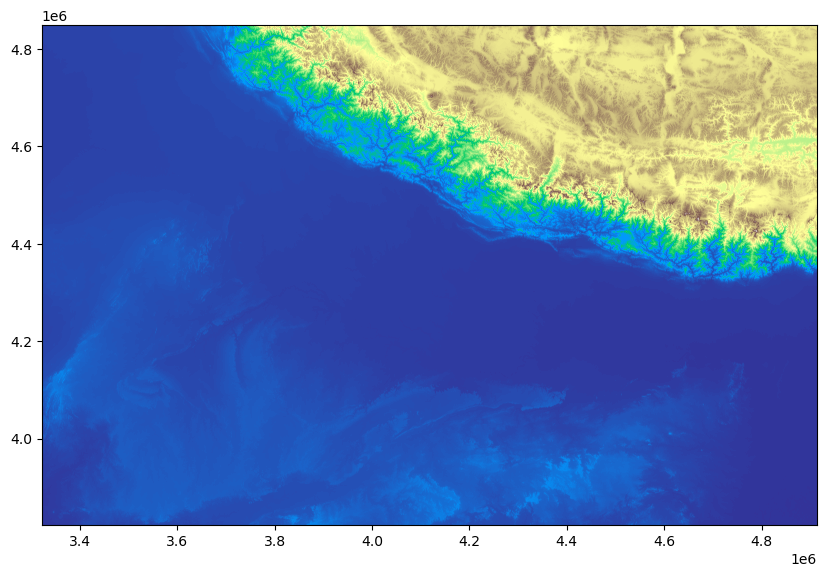

In [14]:
plt.figure(figsize=(10, 8))

# Plot DEM as an image
plt.imshow(dem_dataset.read(1), cmap='terrain', extent=[dem_dataset.bounds.left, dem_dataset.bounds.right, dem_dataset.bounds.bottom, dem_dataset.bounds.top])

# Scatter plot of latitude and longitude points
plt.scatter(df['lon'], df['lat'], c=df['elevation'], cmap='viridis', s=50, marker='o', edgecolors='k', label='Points')

# Add colorbar
cbar = plt.colorbar()
cbar.set_label('Elevation')

# Add labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('DEM with Lat-Long Points')

# Show the plot
plt.show()